# OCMC 2024 Workshop: Computational Visual Analysis
### Author: Yingdan Lu (Department of Communication Studies, Northwestern University)

In this tutorial, we will be covering the following basics about computational visual analysis:

1. Basic image operations
2. Basic color features
3. Basic facial features (FACE++)
4. Basic visual analysis of videos

Acknowledgment: Stanford [CS131](http://vision.stanford.edu/teaching/cs131_fall2021/) & [CS230](https://cs230.stanford.edu/) course materials; course materials, paper replication files, Github code from [Yingdan Lu](https://yingdanlu.com/teaching/) from Northwestern University, [Yilang Peng](https://yilangpeng.com/) from University of Georgia, and [Images as Data for Social Science Research](https://codeocean.com/capsule/8598879/tree/v1).

In [1]:
!pip3 install boto3 pyemd opencv-python pillow webcolors

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 963.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 666.6/666.6 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 4.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/visuals_as_data

In [ ]:
from PIL import Image, ImageFilter
import numpy as np
import cv2
import webcolors
import base64
import os, sys
import matplotlib.pyplot as plt
import requests
import io
import boto3
import json

## install Athec package
athec_path = os.path.expanduser("athecmain/")
sys.path.append(athec_path)
from athec import misc, color

In [ ]:
# img_folder_path = '/content/drive/MyDrive/image_as_data/images/'
img_folder_path = 'images/'
vid_folder_path = 'videos/'

# BASIC IMAGE OPERATIONS

### Read an image

In [ ]:
img = Image.open(os.path.join(img_folder_path, 'dog.jpeg'))
img = img.convert("RGB") # convert the image to the "RGB" mode, regardless of its original mode
img

You can also use other packages like skimage.io.imread (skimage) or cv2 to read an image, but keep in mind that their ***default color channels can be different*** (e.g., RGB for PIL while BGR for cv2)

In [ ]:
# Convert the image object into a NumPy array
img_array = np.array(img)
img_array

array([[[ 91, 129,  72],
        [127, 165, 108],
        [134, 171, 119],
        ...,
        [ 87, 132,  41],
        [ 87, 132,  41],
        [ 87, 132,  41]],

       [[ 97, 135,  78],
        [129, 166, 112],
        [136, 173, 121],
        ...,
        [ 87, 132,  41],
        [ 87, 132,  41],
        [ 87, 132,  41]],

       [[108, 145,  91],
        [132, 169, 115],
        [139, 176, 124],
        ...,
        [ 87, 132,  39],
        [ 87, 132,  39],
        [ 87, 132,  39]],

       ...,

       [[  2,  16,   3],
        [  3,  17,   2],
        [  4,  21,   3],
        ...,
        [123, 164, 106],
        [125, 164, 107],
        [125, 164, 107]],

       [[  1,  15,   2],
        [  4,  18,   3],
        [  8,  22,   5],
        ...,
        [123, 164, 106],
        [125, 164, 107],
        [125, 164, 107]],

       [[  1,  15,   2],
        [  4,  18,   3],
        [  8,  22,   5],
        ...,
        [123, 164, 106],
        [125, 164, 107],
        [125, 164, 107]]

The way computers interpret images is by treating them as ***arrays of numerical pixel values***. Each pixel represents a specific color, which is formed by combining three primary colors: red, green, and blue. Each of these colors is assigned a decimal value, ranging from 0 to 255. A value of 0 indicates complete blackness, while 255 represents pure white. Consequently, every color pixel can be described using three numbers, known as RGB decimal values.
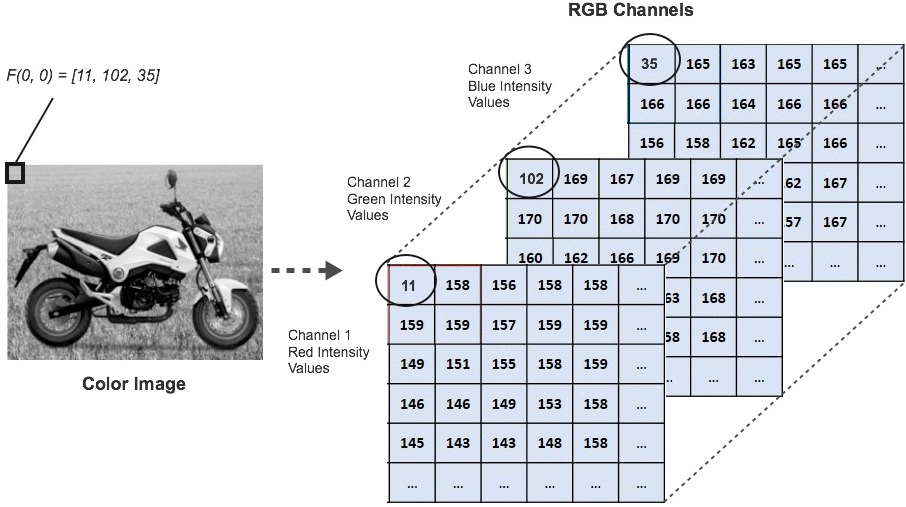

In [ ]:
# Print the shape of the Numpy array
img_array.shape #height of 876 pixels, width of 1200 pixels, and 3 color channels

# COLOR

Among all objective features of an image, the color feature is the most widely explored feature in the literature of information science, communication, psychology and advertisement. Color is the result of interaction between physical light in the environment and our visual system, and we can understand the color features of an image using different descriptors.

**<span style="font-size: larger;">Color space</span>**, also known as the color model (or color system), is an abstract mathematical model which describes the range of colors as tuples of numbers, typically as 3 or 4 values or color components. A colored image can be described with different color spaces. The RGB color space, for example, uses different combinations of red (R), green (G), and blue (B) to reproduce a broad range of colors. Each pixel uses three numbers that range from 0 to 255 to indicate red, green, and blue, respectively. For example, rgb(255, 0, 0) is displayed as red, because red is set to its highest value (255), and the other two (green and blue) are set to 0. In a grayscale image, each pixel is a single number that represents different shades of gray, typically ranging from 0 (black) to 255 (white)
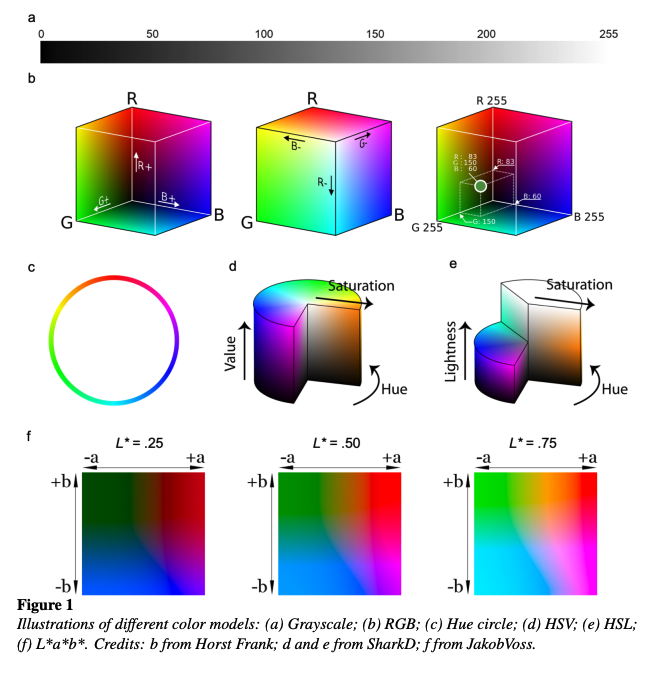



The color space is useful as we can extract specific values (e.g., brightness) from the color space. These specific values are important descriptors of an image. In social science research using images as data, many studies have found that these descriptors can be influencing human perceptions.

### Specific colors

Psychological research finds that different colors may be influencing visual engagement and emotional reactions in different ways. Warm colors like reds and yellows were associated with higher content engagement on social media than cool colors like blues and greens, according to prior research on images.

We can use the ***color.attr_color_percentage*** function in the ***Athec*** package (Peng, 2022) to calculate the percentage of eleven basic colors in an image.

In [ ]:
# Open two images and see how they differ
image1 = Image.open(os.path.join(img_folder_path, 'dog.jpeg'))
image2 = Image.open(os.path.join(img_folder_path, 'dog_black.jpeg'))

fig, axes = plt.subplots(1, 2)
axes[0].imshow(image1)
axes[0].axis('off')
axes[0].text(0.5, -0.1, "Image A", transform=axes[0].transAxes,
             fontsize=12, ha='center')
axes[1].imshow(image2)
axes[1].axis('off')
axes[1].text(0.5, -0.1, "Image C", transform=axes[1].transAxes,
             fontsize=12, ha='center')
plt.subplots_adjust(wspace=0.1)
plt.show()

In [ ]:
color.attr_color_percentage(os.path.join(img_folder_path, 'dog.jpeg'))

{'black': 0.03300894216133942,
 'blue': 0.00037290715372907153,
 'brown': 0.04683124048706241,
 'gray': 0.0033171613394216135,
 'green': 0.8369092465753425,
 'orange': 0.008891742770167427,
 'pink': 0.006832191780821918,
 'purple': 0.00015886605783866058,
 'red': 4.9467275494672755e-05,
 'white': 0.041435502283105025,
 'yellow': 0.02219273211567732,
 'color_shannon': 0.41540076100150003,
 'color_simpson': 0.17318151781070779}

In [ ]:
color.attr_color_percentage(os.path.join(img_folder_path, 'dog_black.jpeg'))

{'black': 0.9901822916666667,
 'blue': 0.00014791666666666667,
 'brown': 5.4166666666666664e-05,
 'gray': 0.009416666666666667,
 'green': 6.25e-06,
 'orange': 0,
 'pink': 0,
 'purple': 3.125e-06,
 'red': 0,
 'white': 0.00018958333333333332,
 'yellow': 0,
 'color_shannon': 0.7652330271847139,
 'color_simpson': 0.4439806838312018}

### Other color features

Athec also enables us to compute other color descriptors and features (including brightness, contrast, etc.). See more in Peng (2022): https://www.aup-online.com/content/journals/10.5117/CCR2022.1.009.PENG

In [ ]:
# Write a function to compute low-level features of an image
def color_dict(img_name):

    result = {}

    """
    Calculate summary statistics of RGB channels.
    """
    result_1 = color.attr_RGB(img_name, return_full = False)
    result.update(result_1)

    """
    Calculate summary statistics of HSV channels.
    """
    result_2 = color.attr_HSV(img_name, return_full = False)
    result.update(result_2)

    """
    Calculate summary statistics of HSL channels.
    """
    result_3 = color.attr_HSL(img_name,return_full = False)
    result.update(result_3)

    """
    Calculate summary statistics of XYZ channels
    """
    result_4 = color.attr_XYZ(img_name,return_full = False)
    result.update(result_4)

    """
    Calculate summary statistics of Lab channels
    """
    result_5 = color.attr_Lab(img_name,return_full = False)
    result.update(result_5)

    """
    Calculate summary statistics of grayscale channel
    """
    result_6 = color.attr_grayscale(img_name,return_full = False)
    result.update(result_6)

    """
    Calculate contrast based on a range that covers a certain percentage of the brightness histogram.
    Return the range and its lower and upper limits.
    save_path (optional, default None): str. If provided, a visualization will be saved to this location.
    threshold (optional, default 0.9): float. The percentage the range covers.
    """
    result_7 = color.attr_contrast_range(img_name,threshold = 0.90)
    result.update(result_7)

    """
    Calculate contrast based on peak detection on the brightness histogram.
    """
    result_8 = color.attr_contrast_peak(img_name,
                                  savgol_filter_window_length = 51,
                                  savgol_filter_polyorder = 5,
                                  savgol_filter_mode = "constant",
                                  argrelmax_order = 20)
    result.update(result_8)

    """
    Calculate colorfulness based on the formula in Hasler and Suesstrunk (2003)
    """
    result_9 = color.attr_colorful(img_name)
    result.update(result_9)

    """
    Calculate colorfulness based on the distance between two color distributions (Datta et al., 2006)
    """
    result_10 = color.attr_colorful_emd(img_name)
    result.update(result_10)

    """
    Calculate percentages of eleven specific colors and color variety measures based on color percentages (excluding black, white, and gray).
    color_dict (optional, default None): if not provided, the function will automatically import the dictionary using colordict.color_dict().
    save_path (optional, default None): str. If provided, a visualization will be saved to this location.
    """
    result_11 = color.attr_color_percentage(img_name)
    result.update(result_11)

    """
    Calculate color variety based on hue count formula in Ke et al. (2006).
    save_path (optional, default None): str. If provided, a visualization will be saved to this location.
    saturation_low (optional, default 0.2): float. The lower limit for saturation. Pixels with saturation below the limit are discarded.
    value_low (optional, default 0.15): float. The lower limit for value. Pixels with value below the limit are discarded.
    value_high (optional, default 0.95): float. The upper limit for value. Pixels with value above the limit are discarded.
    hue_count_alpha (optional, default 0.05): float. Alpha in the hue count formula.
    """
    result_12 = color.attr_hue_count(img_name,
                              saturation_low = 0.2,
                              value_low = 0.15,
                              value_high = 0.95,
                              hue_count_alpha = 0.05)
    result.update(result_12)

    return result

In [ ]:
color_dict(os.path.join(img_folder_path, 'dog.jpeg'))

{'RGB_R_mean': 104.83219558599696,
 'RGB_R_std_dev': 59.653873194558216,
 'RGB_G_mean': 64.6208247716895,
 'RGB_G_std_dev': 62.26057242994583,
 'RGB_B_mean': 133.35370814307458,
 'RGB_B_std_dev': 57.79401103995823,
 'HSV_H_mean': 44.76789668949772,
 'HSV_H_std_dev': 13.465925230843231,
 'HSV_S_mean': 152.39147926179604,
 'HSV_S_std_dev': 74.92059836925603,
 'HSV_V_mean': 135.88221461187214,
 'HSV_V_std_dev': 59.46957069418437,
 'HSV_H_circular_mean': 44.65830556958143,
 'HSV_H_circular_std_dev': 12.614219263578397,
 'HSL_H_mean': 44.75298040334855,
 'HSL_H_std_dev': 13.456999494330354,
 'HSL_S_mean': 138.89776921613395,
 'HSL_S_std_dev': 73.37070108789086,
 'HSL_L_mean': 100.1892151826484,
 'HSL_L_std_dev': 56.90706329002597,
 'HSL_H_circular_mean': 44.64403674053008,
 'HSL_H_circular_std_dev': 12.605384671331668,
 'XYZ_X_mean': 102.58372241248098,
 'XYZ_X_std_dev': 53.83821699219424,
 'XYZ_Y_mean': 122.32973744292238,
 'XYZ_Y_std_dev': 56.78026691055042,
 'XYZ_Z_mean': 79.213663432267

In [ ]:
color_dict(os.path.join(img_folder_path, 'dog_black.jpeg'))

{'RGB_R_mean': 9.745367708333333,
 'RGB_R_std_dev': 18.75933525664064,
 'RGB_G_mean': 9.722428125,
 'RGB_G_std_dev': 18.75909592426766,
 'RGB_B_mean': 9.725205208333334,
 'RGB_B_std_dev': 18.746399190621638,
 'HSV_H_mean': 0.9082135416666667,
 'HSV_H_std_dev': 10.974407692645658,
 'HSV_S_mean': 0.5187708333333333,
 'HSV_S_std_dev': 6.986825679268273,
 'HSV_V_mean': 9.762172916666668,
 'HSV_V_std_dev': 18.83798043921994,
 'HSV_H_circular_mean': 0.02373990642178914,
 'HSV_H_circular_std_dev': 2.937836536470725,
 'HSL_H_mean': 0.9079739583333334,
 'HSL_H_std_dev': 10.971041282971044,
 'HSL_S_mean': 0.34485,
 'HSL_S_std_dev': 5.649841935325858,
 'HSL_L_mean': 9.733634375,
 'HSL_L_std_dev': 18.756583410334045,
 'HSL_H_circular_mean': 0.0235841720284085,
 'HSL_H_circular_std_dev': 2.938366237402207,
 'XYZ_X_mean': 9.277391666666666,
 'XYZ_X_std_dev': 17.816483347261997,
 'XYZ_Y_mean': 9.728183333333334,
 'XYZ_Y_std_dev': 18.74794625062673,
 'XYZ_Z_mean': 10.57131875,
 'XYZ_Z_std_dev': 20.424

# FACES

Facial features can be easily computed using off-the-shelf APIs. Among the popular choices is the Face++ API.

**Face++ Image Requirements:**
*   Format : JPG (JPEG), PNG
*   Size : between 48x48 and 4096x4096 (pixels)
*   File size : no larger than 2MB
*   Minimal size of face : the bounding box of a detected face is a square. The minimal side length of a square should be no less than 1/48 of the short side of image, and no less than 48 pixels. For example if the size of image is 4096 * 3200px, the minimal size of face should be 66 * 66px.
  
*   Face++ API document: https://console.faceplusplus.com/documents/5679127
*   Face++ API can conduct face detection in many aspects

In [ ]:
# Prepare the credentials for Face⁺⁺
# USE YOUR CREDENTIALS
http_url = 'https://api-us.faceplusplus.com/facepp/v3/detect'
key = "4GpVFFtf-ywJ5Gg1mXo-TKD2V6ywQlEg"
secret = "xmY1Vm5f4jURK2DCCpRHy4Q0gwVgkrca"

In [ ]:
# Write a function to detect the number of faces
def face_extract(image):
    face_count = 0
    # Read the image and convert it to base64 format (transmit image data reliably and conveniently)
    files = open(image, "rb")
    encoded_string = base64.b64encode(files.read())

    # get response from Face++ API
    response = requests.post(http_url, data={"api_key":key,
                                             "api_secret": secret,
                                             "return_attributes": "gender,smiling,emotion",
                                             'image_base64': encoded_string,
                                             'return_landmark': 1})
    js = json.loads(response.text)

    # results (number of faces)
    face_count = len(js["faces"])
    print(face_count, "faces were detected")

In [ ]:
Image.open(os.path.join(img_folder_path, 'presidents.jpeg'))

In [ ]:
face_extract(os.path.join(img_folder_path, 'presidents.jpeg'))

2 faces were detected


As shown above, besides counting faces you can also calculate more facial attributes of each face using face++. For example, we can know how many faces are male faces, smiling faces, angry faces, etc. You can find more details via this link: https://console.faceplusplus.com/documents/5679127

In [ ]:
# Write a function to detect the number of faces
def face_extract_more(image):
    face_count = 0
    # Read the image and convert it to base64 format (transmit image data reliably and conveniently)
    files = open(image, "rb")
    encoded_string = base64.b64encode(files.read())

    # get response from Face++ API
    response = requests.post(http_url, data={"api_key":key,
                                             "api_secret": secret,
                                             "return_attributes": "gender,smiling,emotion,age",
                                             'image_base64': encoded_string,
                                             'return_landmark': 1})
    js = json.loads(response.text)

    face_count = len(js["faces"])
    print("Total faces: ", face_count)
    print("=================")

    for faceid in range(0, face_count):
       if faceid > 4: continue # Free version of the API only analyzes first five faces
       print("face id: ", faceid)
       this_face = js["faces"][faceid]
       width = this_face["face_rectangle"]["width"]; height = this_face["face_rectangle"]["height"]
       top = this_face["face_rectangle"]["top"]; left = this_face["face_rectangle"]["left"]
       size = width * height
       print("face size: ",size)
       gender = this_face["attributes"]["gender"]["value"]
       age = this_face["attributes"]["age"]["value"]
       emotion_info = this_face["attributes"]["emotion"]
       # Notes on emotion outputs: The value of each field is a floating-point number with 3 decimal places between [0,100].
       # Bigger value of a field indicates greater confidence of the emotion which the field represents. The sum of all values is 100.
       print("gender: ",gender)
       print("age: ",age)
       print("emotion: ",emotion_info)
       print("=================")

In [ ]:
face_extract_more(os.path.join(img_folder_path, 'presidents.jpeg'))
# get output where the face is so that you know which is which

Total faces:  2
face id:  0
face size:  119716
gender:  Male
age:  76
emotion:  {'anger': 26.012, 'disgust': 0.797, 'fear': 7.089, 'happiness': 20.166, 'neutral': 27.616, 'sadness': 7.315, 'surprise': 11.004}
face id:  1
face size:  116964
gender:  Male
age:  70
emotion:  {'anger': 0.022, 'disgust': 0.002, 'fear': 0.134, 'happiness': 0.002, 'neutral': 99.723, 'sadness': 0.005, 'surprise': 0.113}



Besides the above attributes, Face++ API also allows us to detect

1. Beauty: Beauty score for male and female. The value is a floating-point number with 3 decimal places betwee [0,100]. Higher beauty score indicates the detected faces is more beautiful.


2. Headpose: 3D head pose analysis result, including pitch_angle, roll_angle, and yaw_angle. The value of each object is a floating-point number with 6 decimal places between [-180, 180]


3. Blur: face blur condition with a floating-point number with 3 decimal places between [0,100]


4. Eyestatus: including left eye status, right eye status, occlusion of eye, whether or not wearing a dark glass, whether or not the eye is open, etc


5. Eyegaze: eye center location and eye gaze direction


There are also other APIs or pretrained models that can be used for facial recognition and facial attribute analysis, e.g., DeepFace (see: https://github.com/serengil/deepface), face_recognition package (see: https://face-recognition.readthedocs.io/en/latest/readme.html)

One thing to keep in mind is to always **<span style="font-size: larger;">VALIDATE</span>** your results when using these off-the-shelf tools. See one problematic example as below:

In [ ]:
print(face_extract_more(os.path.join(img_folder_path, 'dog.jpeg'))) ## Should be 0 but Face++ tells you there is A HUMAN FACE

Total faces:  1
face id:  0
face size:  31684
gender:  Male
age:  41
emotion:  {'anger': 2.63, 'disgust': 0.066, 'fear': 0.066, 'happiness': 46.824, 'neutral': 31.836, 'sadness': 0.066, 'surprise': 18.513}
None


# BASIC VISUAL ANALYSIS OF VIDEOS

Now that you already know how to work on static images, let's explore how to analyze visuals in video data. Visually, a video can be seen as a sequence of static image frames. To examine visual features from a video, it is important to learn basic operations like loading videos, extracting frames, and applying computer vision approaches to analyze these visual frames.

<div>
<img src="images/videos.png" width="600"/>
</div>

In [ ]:
### Load a video
def load_video(video):
    cap = cv2.VideoCapture(video) # VideoCapture object to access video frames.
    # Check if the video file is opened successfully
    if not cap.isOpened():
        print("Error: Could not open video.")
        return None
    return cap

video_path = 'videos/example.mp4'
cap = load_video(video_path)
cap

< cv2.VideoCapture 0x7de5ba14e3f0>

Total frames:  289


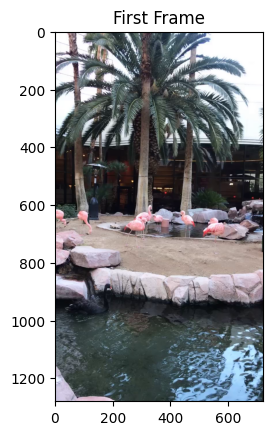

In [ ]:
### Extract frames from the video
def extract_frames(cap):
    frames = [] # Initialize an empty list to store frames
    count = 0 # Frame counter
    while cap.isOpened():
        # Read a frame
        ret, frame = cap.read()
        if not ret:
            break # Exit the loop if the frame loading fails
        frames.append(frame)
        count += 1
    cap.release()
    print("Total frames: ", count)
    return frames

# Extract frames
video_frames = extract_frames(cap)

# Display the first frame
plt.imshow(cv2.cvtColor(video_frames[0], cv2.COLOR_BGR2RGB))
plt.title('First Frame')
plt.show()

In [ ]:
### Convert frames to grayscale

def convert_to_grayscale(frames):
    gray_frames = [cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) for frame in frames]  # Convert each frame to grayscale
    return gray_frames

gray_frames = convert_to_grayscale(video_frames)

# Display the first grayscale frame
plt.imshow(gray_frames[0], cmap='gray')  # Display the first grayscale frame with gray colormap
plt.title('First Grayscale Frame')  # Set the title of the plot
plt.show()  # Show the plot

GoogleVision API, Gemini is great.

You can also use other computer vision techniques that we mentioned above or others to analyze visual frames from videos and derive video-level features.

Besides visuals, you can also analyze textual and auditory information from videos. For example, you can use the Librosa package (https://librosa.org/doc/latest/index.html) to analyze audio features of a video. LLM-based tools like Gemini (see: https://cloud.google.com/vertex-ai/generative-ai/docs/multimodal/video-understanding for video understanding) also enable multimodal analyses that consider text, visuals, and audio of videos.